# DNN Direct


In [15]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  
import pandas as pd
import numpy as np
from scipy import interpolate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt 
import time
import seaborn as sns
from sklearn import metrics
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,GlobalMaxPooling1D
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices("GPU")
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(tf.config.list_physical_devices("GPU")) 
tf.random.set_seed(42)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
def load_data():
    light_curve = os.listdir("final_light_curves")
    max_len = 0 
    X = []
    filenames = []
    for curve in light_curve:
        obj = pd.read_csv(f"final_light_curves/{curve}")
        if len(obj) > max_len:
            max_len = len(obj)


    for curve in light_curve:
        obj = pd.read_csv(f"final_light_curves/{curve}")
        obj["filename"] = curve[:-4]
        obj["Flux"] = obj["Flux"].rolling(window=20, min_periods=1).mean()  # Glättung der Fluxwerte
        obj = obj[["JD", "Flux"]].dropna()
        obj = obj.groupby('JD').mean().reset_index() # einige zeitwerte doppelt -> mittelwert nehmen 
        times = pd.to_datetime(obj["JD"]).astype(np.int64) / 10**9 
        times = times.values
        
        scaler = MinMaxScaler()
        flux = obj["Flux"].values.reshape(-1, 1)
        flux_norm = scaler.fit_transform(flux).flatten()
        
        # Interpolationsfunktion erstellen
        interp_func = interpolate.interp1d(
            times, 
            flux_norm, 
            kind='linear', 
            bounds_error=False, 
            fill_value="extrapolate"
        )
        
        # Gleichmäßige Zeitachse erstellen
        uniform_times = np.linspace(times.min(), times.max(), max_len)
        
        # Flux-Werte interpolieren
        uniform_flux = interp_func(uniform_times)
        
        # Zur Sammlung hinzufügen
        X.append(uniform_flux)
        filenames.append(curve[:-4])
        
        
    # Convert to numpy array
    X = np.array(X)
    
    # 2. Load and prepare labels
    data_y = pd.read_csv("Lichtkurven/galaxienotes.csv")
    data_y["variable"] = data_y["category"] >= 3  # Binary classification (1 if variable)
    data_y = data_y[["name", "variable"]]
    data_y["variable"] = data_y["variable"].astype(int)
    
    # 3. Match filenames with labels
    # Create a dictionary for quick lookup
    label_dict = dict(zip(data_y["name"], data_y["variable"]))
    
    # Get labels for our filenames (assuming filenames match 'name' in galaxienotes.csv)
    y = np.array([label_dict.get(fname, -1) for fname in filenames])  # -1 for unmatched
    
    # Filter out samples without matching labels
    valid_indices = y != -1
    X = X[valid_indices]
    y = y[valid_indices]
    valid_filenames = [fname for i, fname in enumerate(filenames) if valid_indices[i]]
    
    # 4. Train-test split (stratified by class)
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.1, 
        stratify=y, 
        random_state=42
    )
    
    # 5. Standardize the data (important for CNNs)
    # Reshape to 2D for scaling
    original_shape = X_train.shape
    X_train_2d = X_train.reshape(original_shape[0], -1)
    X_test_2d = X_test.reshape(X_test.shape[0], -1)
    
    # Apply StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_2d).reshape(original_shape)
    X_test_scaled = scaler.transform(X_test_2d).reshape(X_test.shape[0], original_shape[1])
    
    return X_train_scaled, X_test_scaled, y_train, y_test, valid_filenames

X_train,X_test,y_train,y_test, valid_filenames = load_data()
print(f"X_train shape: {X_train}, X_test shape: {y_train}")




X_train shape: [[-0.42821507 -0.47493061 -0.51465627 ... -1.52154347 -1.52612496
  -1.52155899]
 [-0.16442722 -0.11882348 -0.07220738 ... -0.66966593 -0.60655474
  -0.54379257]
 [-0.88126988 -0.69352282 -0.45196258 ...  0.04169899 -0.10157595
  -0.48856204]
 ...
 [ 0.35410934  0.30856767  0.22693029 ... -0.37504602 -0.43307687
  -0.49155513]
 [-1.37979746 -1.48222655 -1.53030791 ...  0.92914219  0.92537226
   0.92331545]
 [-0.96380502 -1.01370118 -1.02733158 ...  0.71693675  0.7160466
   0.71656949]], X_test shape: [0 0 0 ... 0 0 0]


Shape of X_train: (1359, 3503)


/var/folders/hs/nb4433114mn3n54wdy7jc0lw0000gn/T/ipykernel_91578/1190820796.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


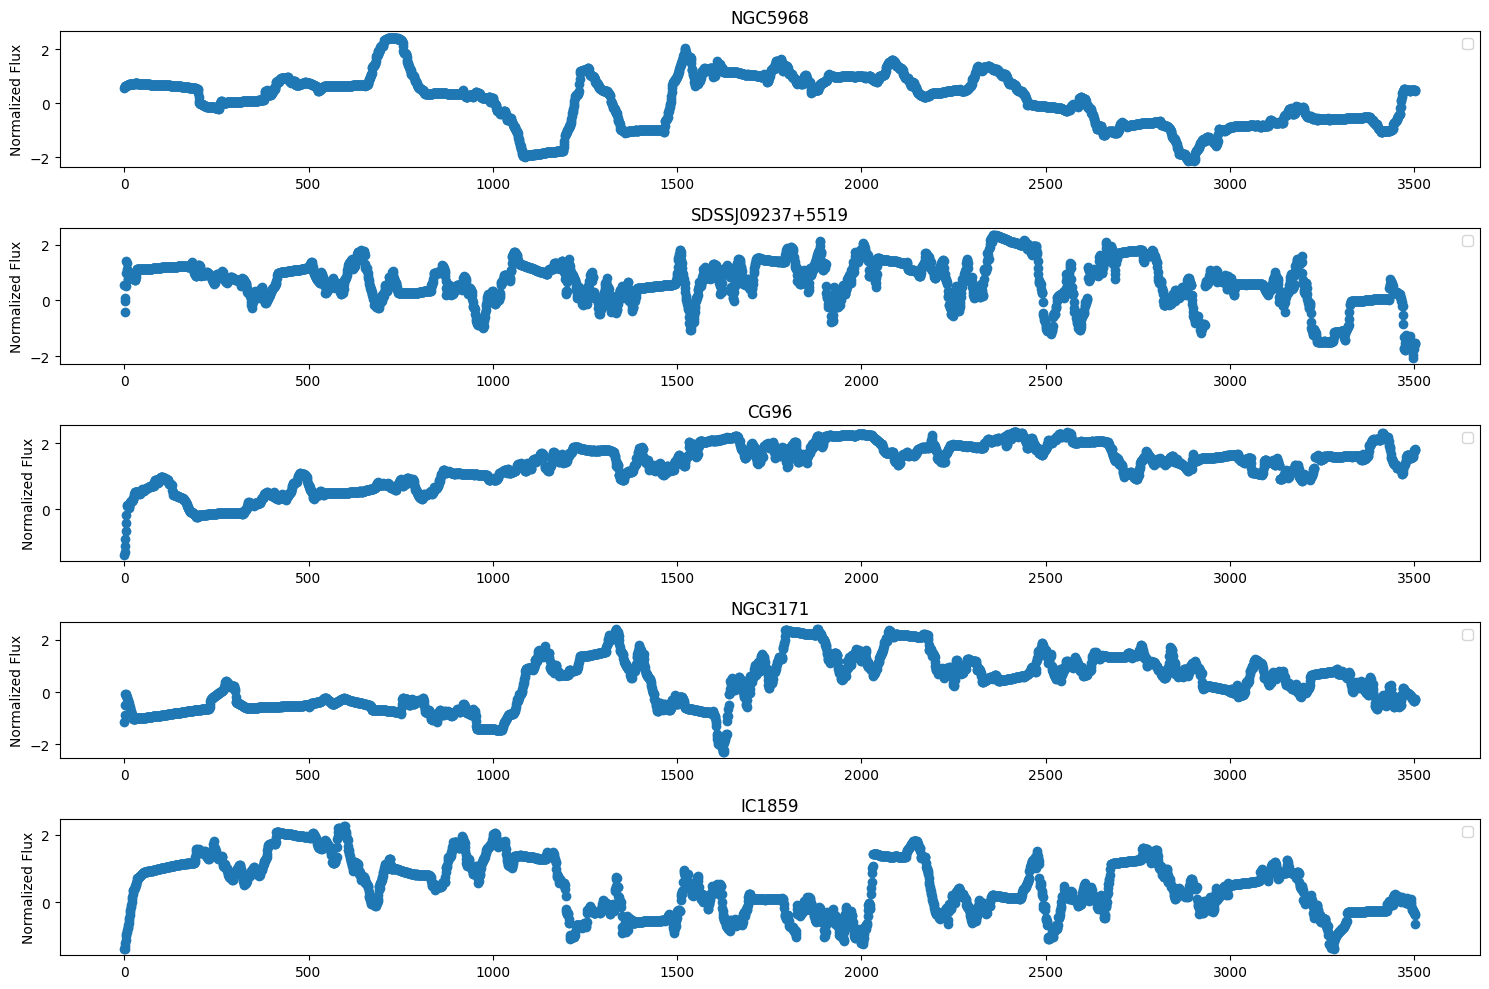

In [17]:
# Test plot light curves 
import random
def show_errors(curve):
    # Plot der ersten 5 falschen Vorhersagen
    print(f"Shape of X_train: {curve.shape}")
    arr = [random.randint(1, curve.shape[0]) for _ in range(5)]
    
    plt.figure(figsize=(15, len(arr)*2))
    for i, idx in enumerate(arr):
        y = np.linspace(0, len(curve[idx]), len(curve[idx]))
        plt.subplot(len(arr), 1, i+1)
        plt.scatter(x=y,y=curve[idx])
        plt.title(f'{valid_filenames[idx]}')
        plt.ylabel('Normalized Flux')
        plt.legend()

    plt.tight_layout()
    plt.show()
show_errors(X_train)

In [39]:
from tensorflow.keras.metrics import Recall, Precision,F1Score
from tensorflow.keras.optimizers.legacy import Adam
def train_model(X_train, y_train, X_test, y_test,layer = [8,32,8] ,batch_size=256, epochs=200,pat=15):

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # shape is 21
    for l in layer:
        if l == max(layer) and l >=5 : # only the biggest layer will have a dropout  
            model.add(Dropout(0.3))
        model.add(Dense(l, activation="relu"))  
    model.add(Dense(1, activation="sigmoid"))    
    #model.summary()
    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[Recall()])
    

    class_weights = compute_class_weight( # because the result should be 85% False and 15% true, so its very important to balance the classes -> without the bias is clearly visible in the results
        "balanced", 
        classes=np.unique(y_train), 
        y=y_train    
    )
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,              
                        validation_data=(X_test, y_test),
                        class_weight=class_weight_dict,
                        callbacks=[EarlyStopping(monitor = "val_loss", patience=pat, restore_best_weights=True)])  

    score = model.evaluate(X_test, y_test, verbose=0)

    return model, history, score

def train_advanced_model(X_train, y_train, X_test, y_test,layer = [[["dense",4]]] ,batch_size=256, epochs=200):
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization,Reshape
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    ehm = "before"
    for i,l in enumerate(layer):
        if l[0] == "conv1d":
            if ehm=="before" or ehm == "dense":
                model.add(Reshape((X_train.shape[1], 1)))
                ehm = False
            if len(l) == 4:
                dil_rate = l[3]
            else:
                dil_rate = 1
            model.add(Conv1D(l[1], kernel_size=l[2],dilation_rate = dil_rate ,activation="relu", padding="same"))
        elif l[0] == "dense":
            model.add(Dense(l[1], activation="relu"))
        elif l[0] == "dropout":
            model.add(Dropout(l[1]))
        elif l[0] == "batchnorm":
            model.add(BatchNormalization())
        elif l[0] == "maxpool":
            model.add(MaxPooling1D(l[1]))
        elif l[0] == "globmaxpool":
            GlobalMaxPooling1D()
        elif l[0] == "flatten":
            model.add(Flatten())
        else:
            print("==== VERSCHRIEBEN ====")
            exit()
        ehm = l[0]
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=[Recall()])
    

    class_weights = compute_class_weight( 
        "balanced", 
        classes=np.unique(y_train), 
        y=y_train    
    )
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,              
                        validation_data=(X_test, y_test),
                        class_weight=class_weight_dict,
                        callbacks=[EarlyStopping(monitor = "val_loss", patience=25, restore_best_weights=True)])  
    score = model.evaluate(X_test, y_test, verbose=0)

    return model, history, score

In [19]:
# old plot for single model
def plot_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(accuracy))

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

    axes[0].plot(epochs, accuracy, "bo", label="Training")
    axes[0].plot(epochs, val_accuracy, "r", label="Test")
    axes[0].set_xlabel("Epoch", size=18)
    axes[0].set_ylabel("Accuracy", size=18)
    axes[0].legend()
    axes[0].set_title("Accuracy", size=18)

    axes[1].plot(epochs, loss, "bo", label="Training")
    axes[1].plot(epochs, val_loss, "r", label="Test")
    axes[1].set_xlabel("Epoch", size=18)
    axes[1].set_ylabel("Loss", size=18)
    axes[1].set_yscale("log")  
    axes[1].grid()
    axes[1].legend()
    axes[1].set_title("Loss", size=18)

    plt.tight_layout() 
    plt.show()

In [20]:
# old single cn Matrix
def plot_cn_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test,verbose=0)
    binary_predictions = (y_pred >= 0.5).astype(int) 
    cm1 = metrics.confusion_matrix(y_test, binary_predictions,normalize="true")
    sns.heatmap(cm1, annot=True, fmt=".2f", linewidths=.5, square=True, cmap="Blues_r")
    plt.ylabel("true number", size=14)
    plt.xlabel("predicted number", size=14)
    plt.show()

In [21]:
def plot_all_history(model,X_test, y_test):
    
    model.sort_values(by=["loss"], ascending=True, inplace=True)

    
    fig, axes = plt.subplots(len(model),3, figsize=(16, len(model["model"])*5), layout="constrained")  
    
    index = 0
    for i,m in model.iterrows():
        his = m["history"]
        keys = list(his.history.keys()) # i have to do this if i wanna switch the metric
        layer = m["layer"]        
        #print(keys)
        accuracy = his.history[keys[1]]  
        val_accuracy = his.history[keys[3]]
        loss = his.history["loss"]
        val_loss = his.history["val_loss"]
        epochs = range(len(accuracy))
        # ====== ACC PLOT ========
        ax = axes.flatten()[index]  
        ax.plot(epochs, accuracy, "o-", label=f"Training-acc")
        ax.plot(epochs, val_accuracy, "o-", label=f"Test-acc")
        ax.set_title(f"ACC: {m['acc']:.4f} and LOSS: {m['loss']:.4f},BS:{m['batch_size']}",loc="left")
        ax.legend()
        ax.grid(True)
        # ====== LOSS PLOT ========
        index += 1
        ax = axes.flatten()[index] 
        ax.plot(epochs, loss, "o-", label=f"Training-loss")
        ax.plot(epochs, val_loss, "o-", label=f"Test-loss")
        ax.set_title(f"with Layer: {layer}")
        ax.legend()
        ax.grid(True)
        # ====== MATRIX PLOT ========
        index += 1
        ax = axes.flatten()[index] 
        y_pred = m["model"].predict(X_test,verbose=0)
        binary_predictions = (y_pred >= 0.5).astype(int) 
        cm1 = metrics.confusion_matrix(y_test, binary_predictions,normalize="true")
        sns.heatmap(cm1, annot=True, fmt=".2f", linewidths=.5, square=True, cmap="Blues_r",ax=ax)
        ax.set_ylabel("true number", size=14)
        ax.set_xlabel("predicted number", size=14)
        index += 1
    
    plt.show()
    


  0%|          | 0/14 [00:00<?, ?it/s]/var/folders/hs/nb4433114mn3n54wdy7jc0lw0000gn/T/ipykernel_91578/533761328.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model = pd.concat([model,pd.DataFrame({"model": [m], "history": [h], "acc": [s[1]], "loss":[s[0]],"layer": [str(l)], "batch_size":[256]})], ignore_index=True)
100%|██████████| 14/14 [00:44<00:00,  3.20s/it]


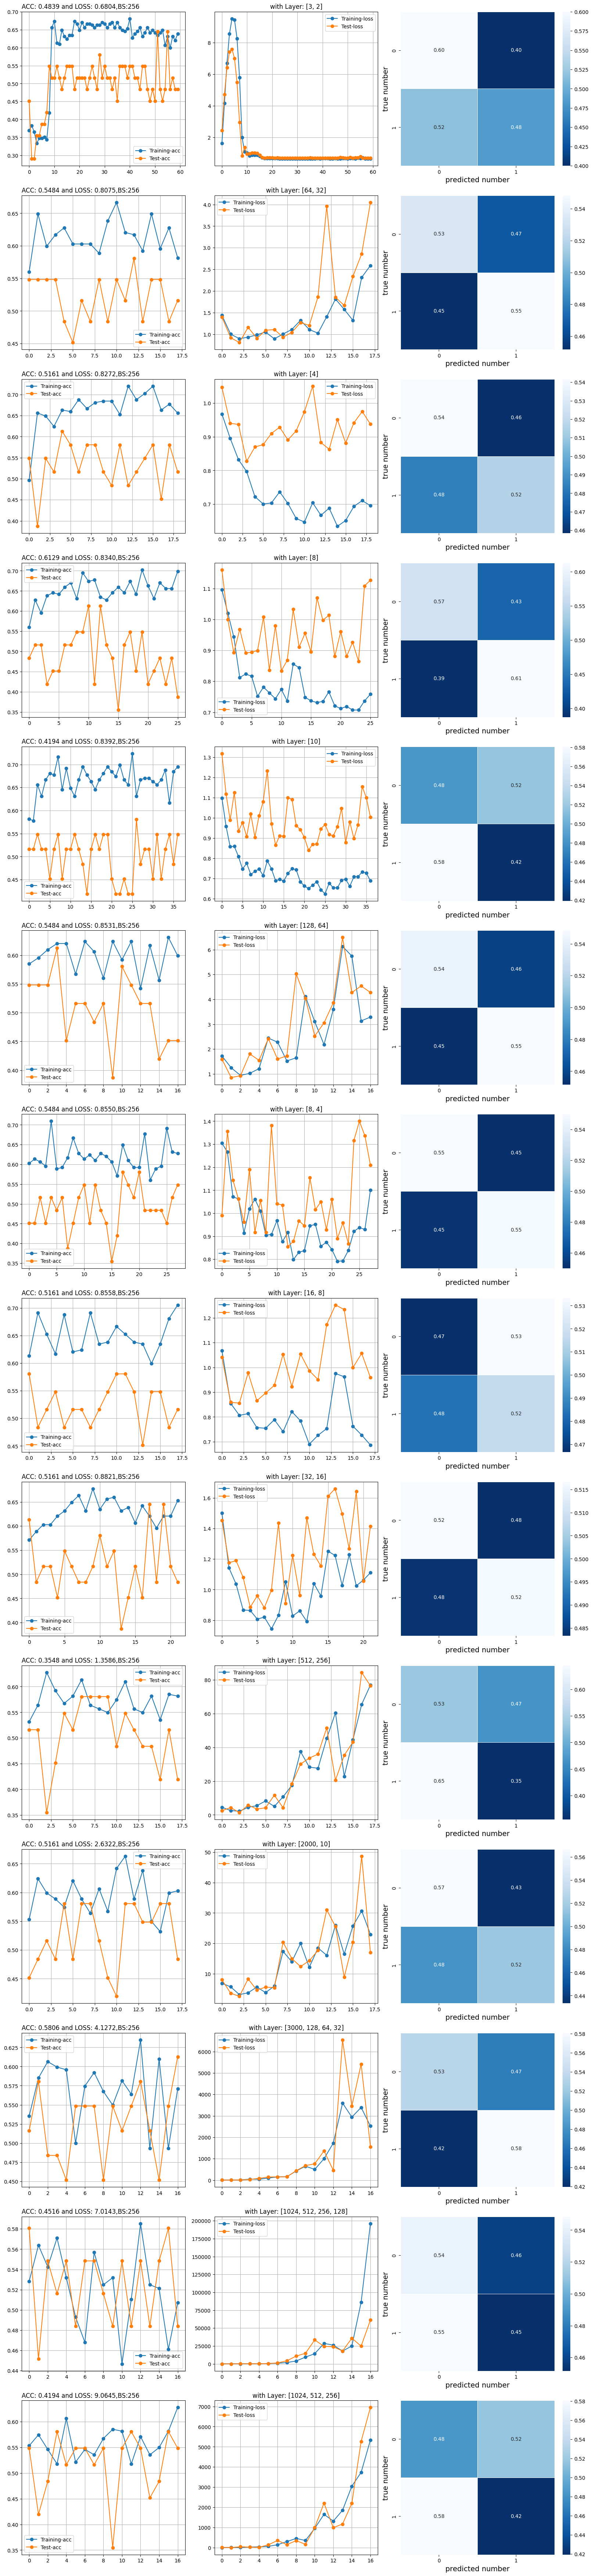

In [22]:
layer_c = [[3000,128,64,32],[1024,512,256,128],[1024,512,256],[512,256],[128,64],[64,32],[32,16],[16,8],[8],[4],[10],[8,4],[3,2],[2000,10]] 

layer = layer_c

model = pd.DataFrame(columns=["model","history","acc","loss" "layer","batch_size"])

for l in tqdm(layer):
    m, h, s = train_model(X_train, y_train, X_test, y_test,layer=l ,batch_size=128, epochs=200) #<- I tried different batch_sizes, 256 seemed best
    model = pd.concat([model,pd.DataFrame({"model": [m], "history": [h], "acc": [s[1]], "loss":[s[0]],"layer": [str(l)], "batch_size":[256]})], ignore_index=True)
    
# print("Test loss: {:.4f}".format(score[0]))
# print("Test accuracy: {:.4f}".format(score[1]))
plot_all_history(model,X_test=X_test, y_test=y_test)


1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 5ms/step


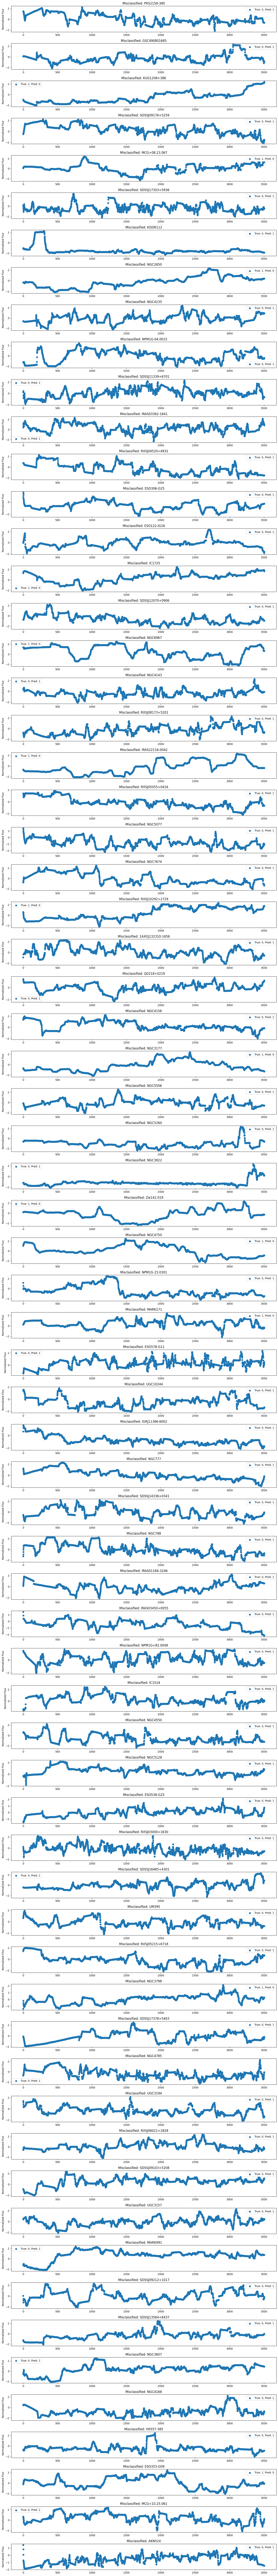

In [23]:
def show_errors(model, X_test, y_test):
    y_pred = model.predict(X_test).round()
    wrong_idx = np.where(y_pred.flatten() != y_test)[0]
    # Plot der ersten 5 falschen Vorhersagen
    plt.figure(figsize=(15, len(wrong_idx)*2))
    for i, idx in enumerate(wrong_idx):
        y = np.linspace(0, len(X_test[idx]), len(X_test[idx]))
        plt.subplot(len(wrong_idx), 1, i+1)
        # Direkter Plot der normalisierten Flux-Werte
        plt.scatter(x=y,y=X_test[idx],label=f'True: {y_test[idx]}, Pred: {int(y_pred[idx])}')
        plt.title(f'Misclassified: {valid_filenames[idx]}')
        plt.ylabel('Normalized Flux')
        plt.legend()

    plt.tight_layout()
    plt.show()
show_errors(model["model"][0], X_test, y_test)

0it [00:00, ?it/s]/var/folders/hs/nb4433114mn3n54wdy7jc0lw0000gn/T/ipykernel_91578/3563460407.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model2 = pd.concat([model2,pd.DataFrame({"model": [m], "history": [h], "acc": [s[1]], "loss":[s[0]],"layer": [str(l)],"batch_size":[bs]})], ignore_index=True)
5it [02:45, 33.10s/it]


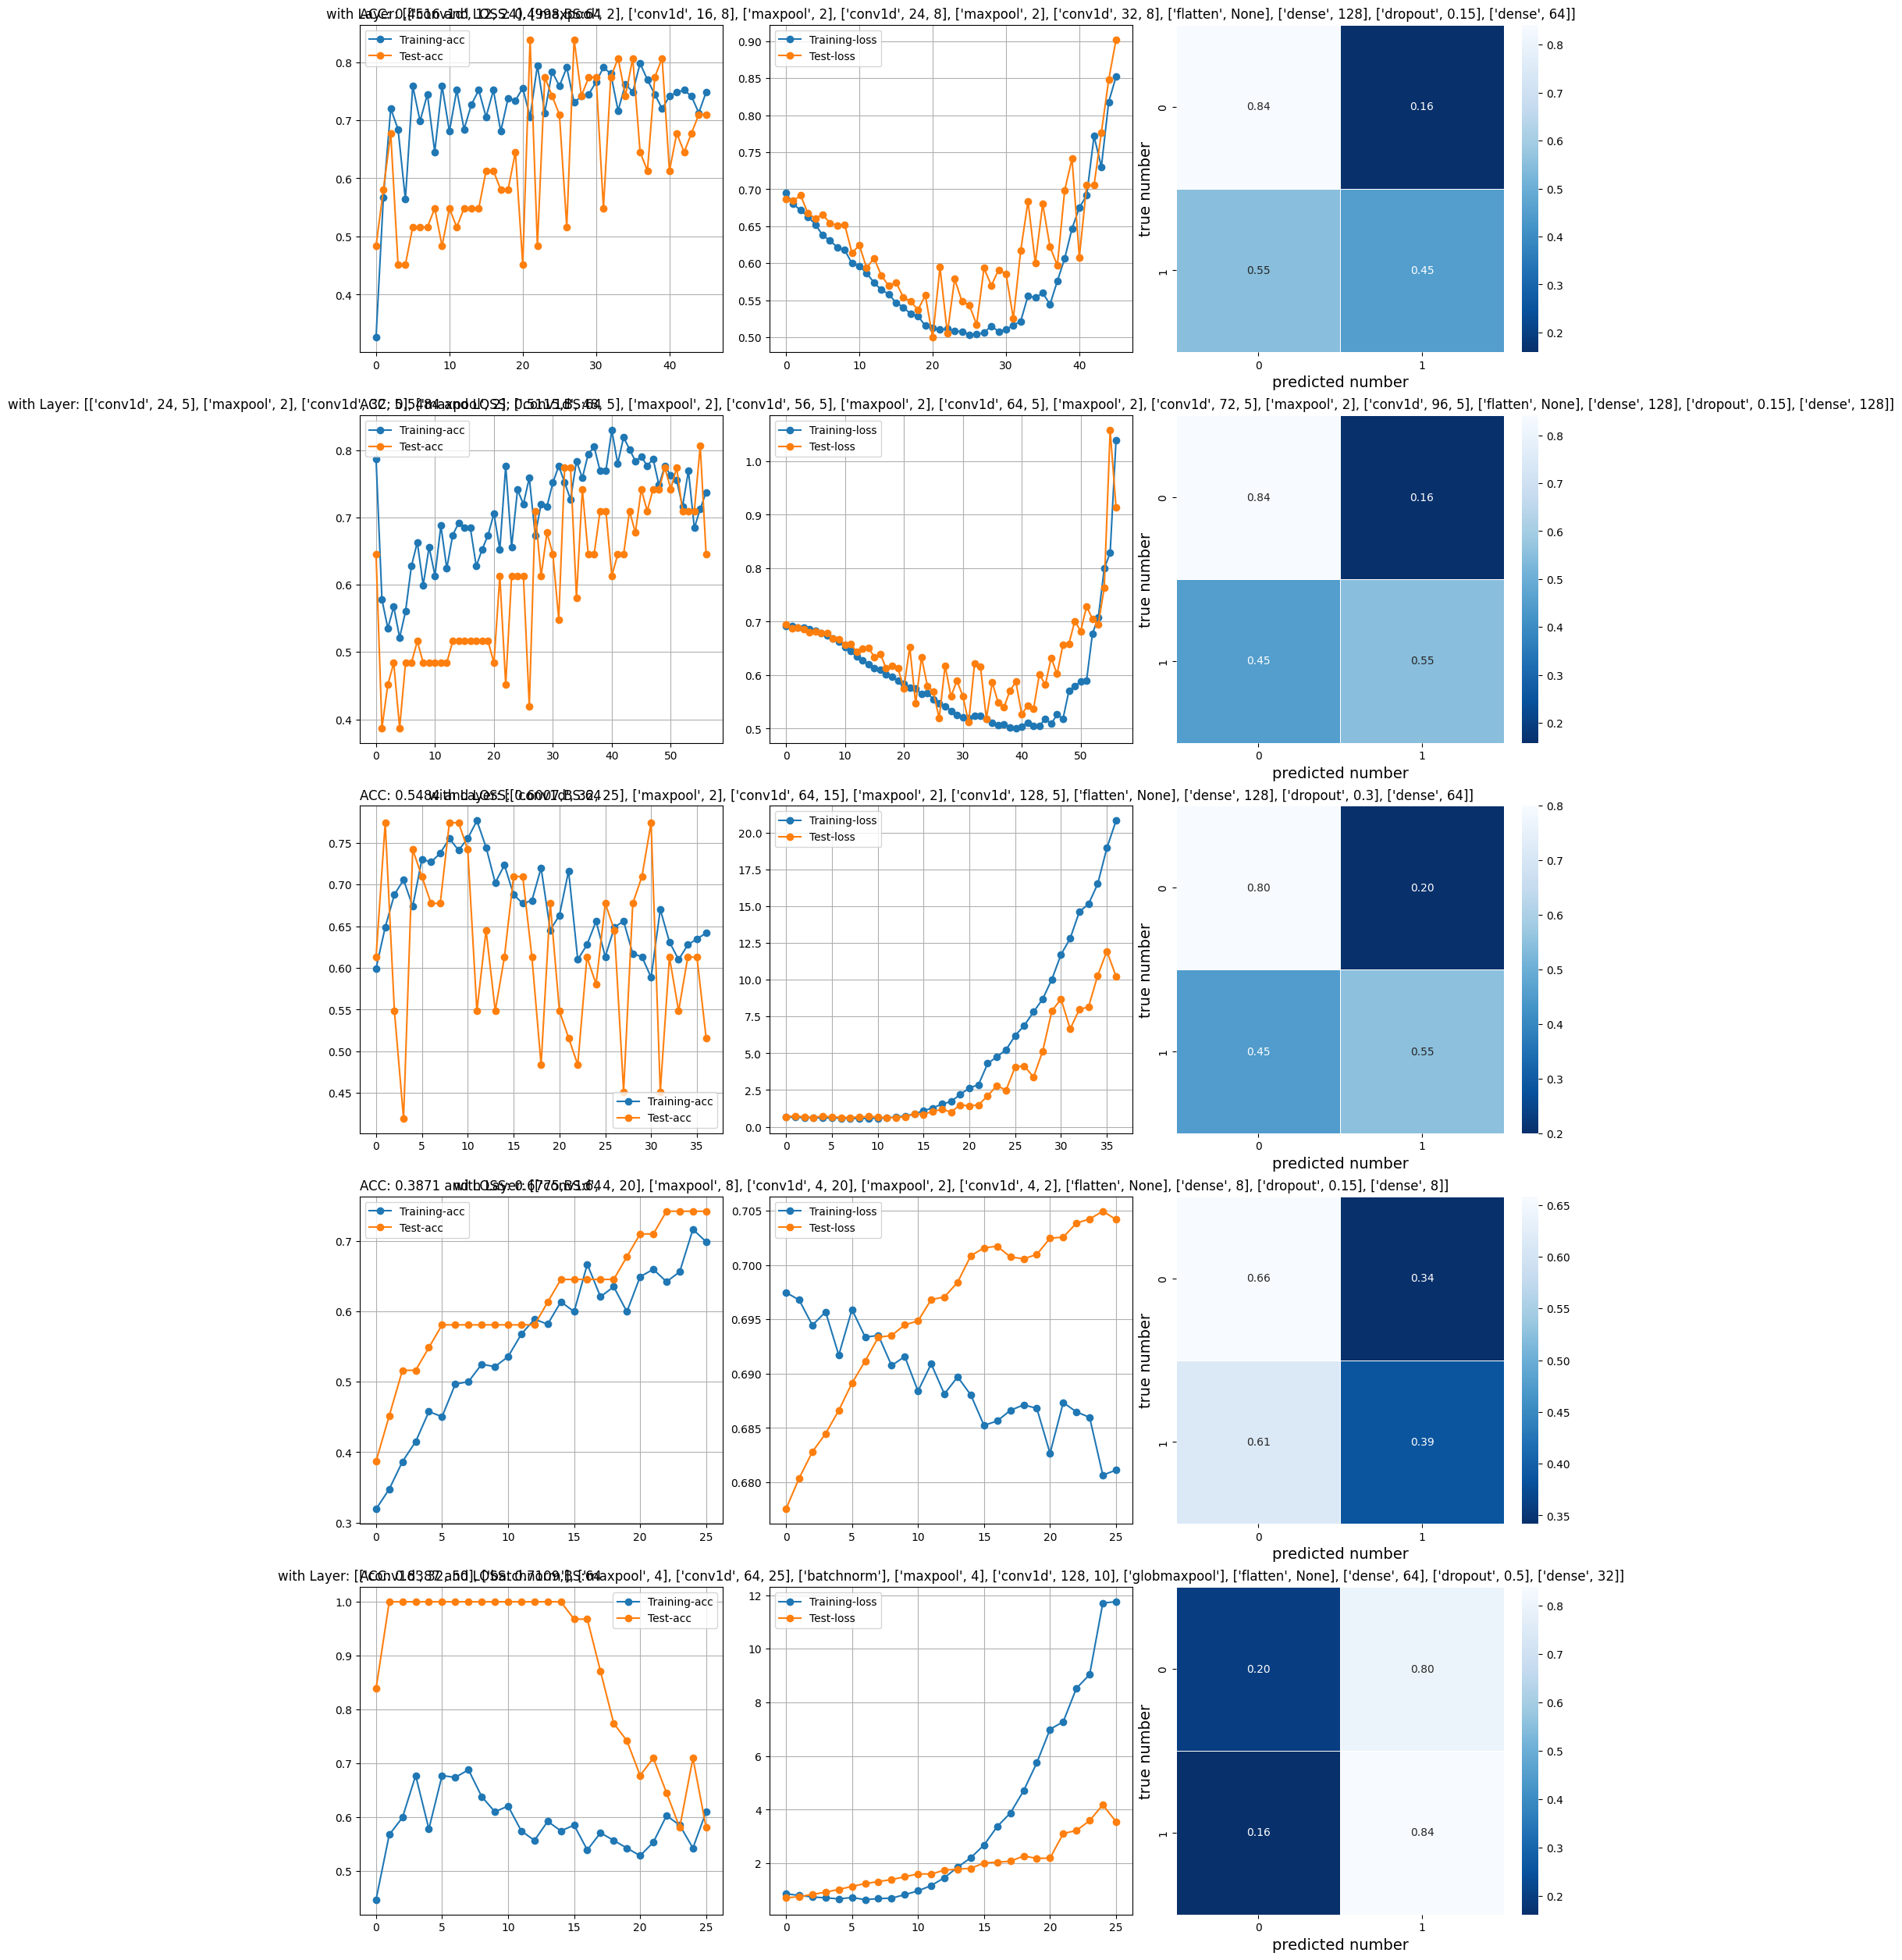

In [42]:


layer = [
    [["conv1d",24,5],["maxpool",2],["conv1d",32,5],["maxpool",2],["conv1d",48,5],["maxpool",2],["conv1d",56,5],["maxpool",2],["conv1d",64,5],["maxpool",2],["conv1d",72,5],["maxpool",2],["conv1d",96,5],["flatten",None],["dense",128],["dropout",0.15],["dense",128]],
    [["conv1d",32,25],["maxpool",2],["conv1d",64,15],["maxpool",2],["conv1d",128,5],["flatten",None],["dense",128],["dropout",0.3],["dense",64]],
    [["conv1d",4,20],["maxpool",8],["conv1d",4,20],["maxpool",2],["conv1d",4,2],["flatten",None],["dense",8],["dropout",0.15],["dense",8]],
    [["conv1d",12,24],["maxpool",2],["conv1d",16,8],["maxpool",2],["conv1d",24,8],["maxpool",2],["conv1d",32,8],["flatten",None],["dense",128],["dropout",0.15],["dense",64]],
    [["conv1d", 32, 50],["batchnorm"],["maxpool", 4],["conv1d", 64, 25],["batchnorm"],["maxpool", 4],["conv1d", 128, 10],["globmaxpool"],["flatten",None],["dense", 64],["dropout", 0.5],["dense", 32]]
]
batch_s = np.full(len(layer), 64)

model2 = pd.DataFrame(columns=["model","history","acc","loss" "layer","batch_size"])

for l,bs in tqdm(zip(layer,batch_s)):
    m, h, s = train_advanced_model(X_train, y_train, X_test, y_test,layer=l ,batch_size=bs, epochs=200)
    model2 = pd.concat([model2,pd.DataFrame({"model": [m], "history": [h], "acc": [s[1]], "loss":[s[0]],"layer": [str(l)],"batch_size":[bs]})], ignore_index=True)
    
plot_all_history(model2,X_test=X_test, y_test=y_test)
